Text(0.5, 1.0, 'by hour')

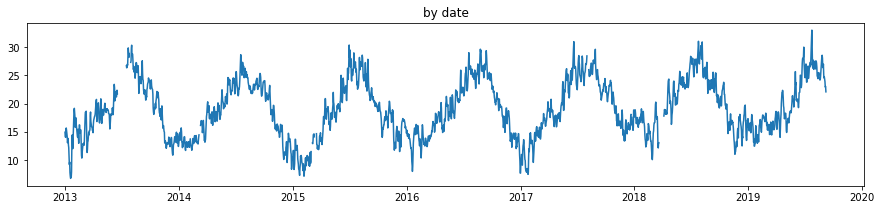

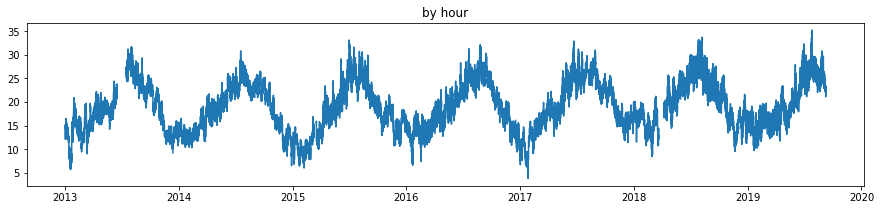

In [11]:
# load JSON
import json
import pandas as pd
 
# hourly data 
data = pd.read_pickle('franklin-d-roosevelt/airQualityDataframe-franklin-d-roosevelt-temp.pkl')
data = data.sort_values(by=['ds'])
data['just_date'] = data['ds'].dt.date
df_h = data

# group by date
data_d = data.groupby(['just_date'],squeeze=True).mean()
data_d.columns = ['_'.join(col).strip() for col in data_d.columns.values]
data_d = data_d.reset_index()
data_d.columns = ['ds','y'] # rename column
df_d = data_d

import matplotlib.pyplot as plt
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
plt.figure(figsize=(15,3))
plt.plot(df_d['ds'],df_d['y'])
plt.title('by date')
plt.figure(figsize=(15,3))
plt.plot(df_h['ds'],df_h['y'])
plt.title('by hour')

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


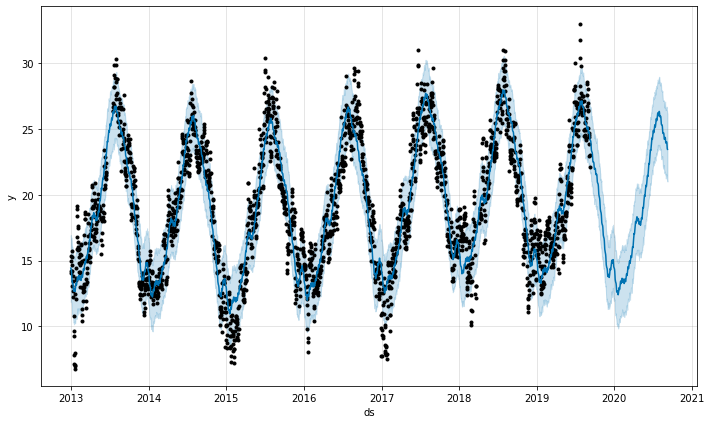

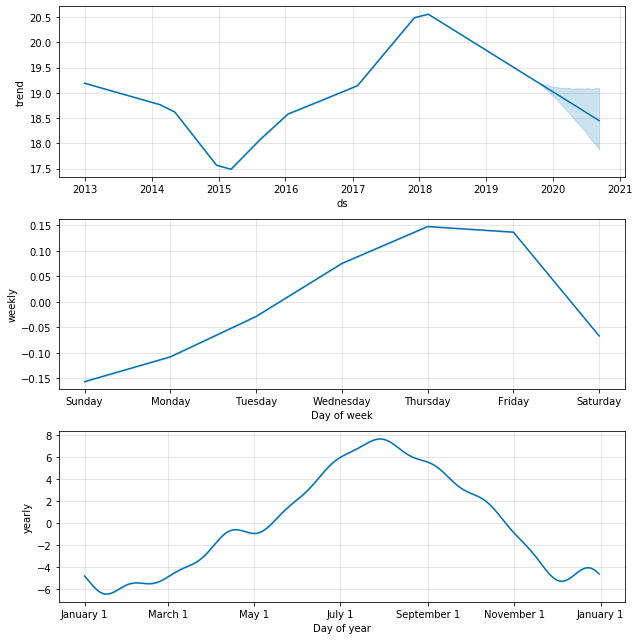

In [12]:
df = df_d # select daily or hourly daya

from fbprophet import Prophet

m = Prophet(changepoint_prior_scale=0.1) #  Increasing scale will make the trend more flexible:
m.fit(df)
future = m.make_future_dataframe(periods=365, freq='D')
forecast = m.predict(future)
pd.plotting.register_matplotlib_converters() # this resolves some issues with data type
fig = m.plot(forecast)
components_fig = m.plot_components(forecast)

In [14]:
# PROPHET validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='1000 days', period='100 days', horizon ='365 days') # horizon: forecast ; initial: training (default: 3x horizon); 
df_cv.head()

INFO:fbprophet:Making 11 forecasts with cutoffs between 2015-12-13 00:00:00 and 2018-09-08 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2015-12-14,12.623834,10.250726,14.817115,12.341667,2015-12-13
1,2015-12-15,12.735243,10.429389,14.953107,14.083333,2015-12-13
2,2015-12-16,13.005244,10.667327,15.282320,15.887500,2015-12-13
3,2015-12-17,13.187726,10.754461,15.453225,16.629167,2015-12-13
4,2015-12-18,13.277014,11.033036,15.441727,16.925000,2015-12-13


In [16]:
# Percentage errors
mape = 100*sum(abs( (df_cv.yhat - df_cv.y) / df_cv.y) ) / len(df_cv) # MAPE
smape = 100*sum( abs(df_cv.yhat - df_cv.y) / (abs(df_cv.yhat) + abs(df_cv.y)) ) /len(df_cv) / 2 # SMAPE
print('MAPE = ' + str(mape) + '%')
print('SMAPE = ' + str(smape) + '%')

MAPE = 11.818418733124545%
SMAPE = 2.8211407527769206%


In [ ]:
#import pickle
#pkl_path = "franklin-d-roosevelt/PM10_m.pkl"
#with open(pkl_path, "wb") as f:
#    # Pickle the 'Prophet' model using the highest protocol available.
#    pickle.dump(m, f)

## save the dataframe
#forecast.to_pickle("franklin-d-roosevelt/PM10_forecast.pkl")
#print("*** Data Saved ***")

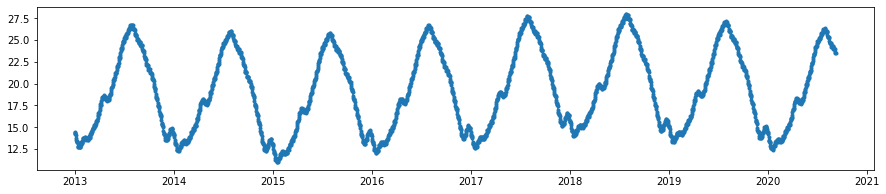

In [17]:
plt.figure(figsize=(15,3))
plt.plot(forecast.ds,forecast.yhat,marker='.')
#plt.figure(figsize=(15,3))
plt.plot(data_d.ds[50001:52160],data_d.y[50001:52160])